In [1]:
import face_align
import onnx
import onnxruntime
import os
import pickle
import numpy as np
from PIL import Image
from typing import List
from tqdm import tqdm
import insightface
from sklearn.neighbors import NearestNeighbors
import cv2
from SCRFD import SCRFD
import time
from ArcFace import ArcFaceONNX
import matplotlib.pyplot as plt

<h1> install buffalo_l model </h1>
<a>'det_10g.onnx': detection </a> <br/>
<c>'w600k_r50.onnx': recognition </c> 

In [2]:
#app = FaceAnalysis(name="antelope")
model_name = 'buffalo_l'
app = insightface.app.FaceAnalysis(model_name)
assets_dir = os.path.expanduser('~/.insightface/models/buffalo_l')
print(os.listdir(assets_dir))

d:\miniconda3\envs\faceRecognition\lib\site-packages\onnxruntime\capi\onnxruntime_inference_collection.py:65: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\MSI/.insightface\models\buffalo_l\1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\MSI/.insightface\models\buffalo_l\2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\MSI/.insightface\models\buffalo_l\det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\MSI/.insightface\models\buffalo_l\genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\MSI/.insightface\models\buffalo_l\w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
['

In [3]:
print(onnxruntime.get_device())

CPU


In [4]:
def arc_detector():
  detector = SCRFD(os.path.join(assets_dir, 'det_10g.onnx'))
  detector.prepare(0)
  return detector

In [5]:
detector = arc_detector()
print(detector)

In [6]:
def plot_one_box(x, img, color=None, label=None, line_thickness=3):
    # Plots one bounding box on image img
    tl = line_thickness or round(0.002 * (img.shape[0] + img.shape[1]) / 2) + 1  # line/font thickness
    c1, c2 = (int(x[0]), int(x[1])), (int(x[2]), int(x[3]))
    cv2.rectangle(img, c1, c2, color, thickness=tl, lineType=cv2.LINE_AA)
    if label:
        tf = max(tl - 1, 1)  # font thickness
        t_size = cv2.getTextSize(label, 0, fontScale=tl / 3, thickness=tf)[0]
        c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
        cv2.rectangle(img, c1, c2, color, -1, cv2.LINE_AA)  # filled
        cv2.putText(img, label, (c1[0], c1[1] - 2), 0, tl / 3, [225, 255, 255], thickness=tf, lineType=cv2.LINE_AA)


In [7]:
def Area(rect):
  return (rect[2] - rect[0]) * (rect[3] - rect[1])

Test for a image have two more face


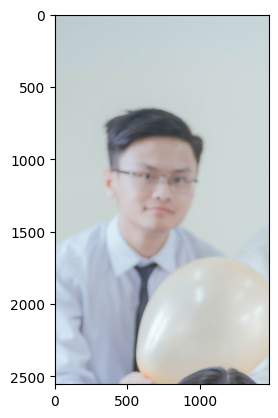

In [7]:
image_path = 'DSC_3459.jpg'
img = cv2.imread(image_path)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [9]:
boxs, kpss = detector.autodetect(img)

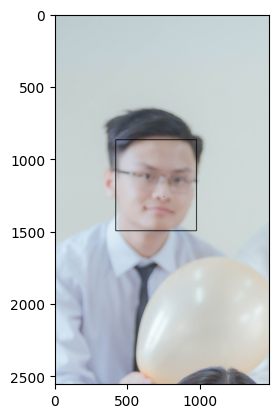

In [10]:
#sort all and get the largest area one
all = [(_,x) for _,x in sorted(zip(boxs, kpss), key = lambda e: -Area(e[0]))]
sorted_boxs = [i[0] for i in all]
sorted_kpss = [i[1] for i in all]
for x,y in sorted_kpss[0]: #khuon mat chinh giua
  cv2.circle(img, (int(x), int(y)), radius=3, color=(0, 0, 255), thickness=-1)
plot_one_box(sorted_boxs[0][:4], img)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [8]:
def arc_model():
  rec = ArcFaceONNX(os.path.join(assets_dir, 'w600k_r50.onnx'))
  rec.prepare(0)
  return rec

In [9]:

app = arc_model()

In [34]:
def generate_embs(img_fpaths: List[str], app, detector, label, path): #ham tao embeeding cua 1 anh
    embs_set = list()
    embs_label = list()

    for img_fpath in img_fpaths:  
       #read image
        img = cv2.imread(os.path.join(path, img_fpath))
        if img is None:
          print(f'{img_fpath} of number {label} Error. No image found. Skip')
        boxs, kpss = detector.autodetect(img)
        if len(kpss) == 0:
          print(f'{img_fpath} of number {label} Error. No face spotted. Skip')
          continue
      #  # generate Insightface embedding
        if len(kpss) > 1: #choose the largest one
          kpss = [x for _,x in sorted(zip(boxs, kpss), key = lambda e: -Area(e[0]))]
        try:
          emb_res = app.get(img, kpss[0])         
          embs_set.append(emb_res)          
          embs_label.append(label)
        except:
          print(f'\nno embedding found for this image: {img_fpath} of number {label}')         

    return embs_set, embs_label

In [17]:
input_dir = "Face Data/Face Dataset" 
files = os.listdir(input_dir)
files.sort(key = lambda x: int(x))

In [18]:
#check total of files
total = 0
for i in files:
  path = input_dir + '/' + i
  if len(os.listdir(path)) >= 5: total+=1
print(total) #316

51


In [19]:
from sklearn.model_selection import train_test_split


In [20]:
def generate_train_and_test(path_dir):
  train, test = train_test_split(path_dir)
  return train, test

In [19]:
embs = list() #train_embs
labels = list() #train_labels
probe_embs = list() #test_embs
probe_labels = list() #test_labels
start = time.time()
total = 0
for i in files:
  path = input_dir + '/' + i
  if len(os.listdir(path)) < 5: continue
  total += len(os.listdir(path))
  #
  t1 = time.time()
  path = input_dir + '/' + i
  allFile = os.listdir(path)

  eval, probe = generate_train_and_test(allFile)
  emb, label = generate_embs(eval, app, detector, str(i) ,path)
  embs.extend(emb)
  labels.extend(label)
  probe_emb, probe_label = generate_embs(probe, app, detector, str(i), path)
  probe_embs.extend(probe_emb)
  probe_labels.extend(probe_label)
  tt = time.time() - t1
  print(f"Finished at {i}. Time: {tt} for {len(os.listdir(path))} images")

end = time.time()
print(f"Embeeding {total} image: {end-start} seconds")

Finished at 6. Time: 6.025899648666382 for 19 images
Finished at 17. Time: 3.550473928451538 for 12 images
Finished at 19. Time: 1.5648159980773926 for 5 images
Finished at 23. Time: 1.5039780139923096 for 5 images
Finished at 27. Time: 1.5997543334960938 for 5 images
Finished at 29. Time: 1.4930098056793213 for 5 images
Finished at 32. Time: 1.774219036102295 for 6 images
Finished at 38. Time: 11.59998607635498 for 39 images
Finished at 54. Time: 2.3776419162750244 for 8 images
Finished at 57. Time: 1.7247705459594727 for 5 images
Finished at 60. Time: 11.007562637329102 for 35 images
Finished at 62. Time: 2.3876161575317383 for 8 images
Finished at 64. Time: 2.18518328666687 for 7 images
Finished at 69. Time: 2.212085247039795 for 7 images
Finished at 70. Time: 6.116615533828735 for 21 images
Finished at 74. Time: 2.2879130840301514 for 7 images
Finished at 75. Time: 2.363646984100342 for 8 images
Finished at 83. Time: 12.752861499786377 for 36 images
Finished at 85. Time: 4.74930000

In [16]:
embs, labels, probe_embs, probe_labels = load_embs()

In [38]:
embs = list(embs)
labels = list(labels)
probe_embs = list(probe_embs)
probe_labels = list(probe_labels)
print(type(embs))

<class 'list'>


In [44]:
print(len(embs), len(probe_embs))
assert len(embs) == len(labels)
assert len(probe_embs) == len(probe_labels)

2525 1033


In [42]:
path = "Face Data\Face Dataset\\1681"
#PHPath = "Face Data\Face Dataset\\000"
allFile = os.listdir(path)
print(allFile)
eval, probe = generate_train_and_test(allFile)
print(eval, probe)

['237139808_1424940327879171_1808629527834610780_n.jpg', '31cdf9d6c38410da4995.jpg', '45d902061e54cd0a9445.jpg', 'b1938582bfd06c8e35c1.jpg', 'e213951aaf487c162559.jpg']
['b1938582bfd06c8e35c1.jpg', 'e213951aaf487c162559.jpg', '237139808_1424940327879171_1808629527834610780_n.jpg'] ['45d902061e54cd0a9445.jpg', '31cdf9d6c38410da4995.jpg']


In [33]:
for i in eval:
    print(i)
    print(cv2.imread(os.path.join(path, i)))

345e1709e133306d6922.jpg
[[[231 247 253]
  [231 247 253]
  [231 247 253]
  ...
  [158 171 185]
  [159 172 186]
  [159 172 186]]

 [[231 247 253]
  [231 247 253]
  [231 247 253]
  ...
  [157 170 184]
  [157 170 184]
  [157 170 184]]

 [[231 247 253]
  [231 247 253]
  [231 247 253]
  ...
  [157 170 184]
  [157 170 184]
  [156 169 183]]

 ...

 [[201 224 240]
  [197 220 236]
  [191 213 231]
  ...
  [192 210 227]
  [191 209 226]
  [190 208 225]]

 [[204 227 243]
  [200 223 239]
  [193 215 233]
  ...
  [192 210 227]
  [192 210 227]
  [192 210 227]]

 [[201 224 240]
  [197 220 236]
  [190 212 230]
  ...
  [194 212 229]
  [197 215 232]
  [198 216 233]]]
3x4_small.jpg
[[[218 142  66]
  [218 142  66]
  [218 142  66]
  ...
  [218 142  66]
  [218 142  66]
  [218 142  66]]

 [[218 142  66]
  [218 142  66]
  [218 142  66]
  ...
  [218 142  66]
  [218 142  66]
  [218 142  66]]

 [[218 142  66]
  [218 142  66]
  [218 142  66]
  ...
  [218 142  66]
  [218 142  66]
  [218 142  66]]

 ...

 [[206 178 15

In [43]:

emb, label = generate_embs(eval, app, detector, str(1681) ,path)

probe_emb, probe_label = generate_embs(probe, app, detector, str(1681), path)
probe_embs.extend(probe_emb)
probe_labels.extend(probe_label)
embs.extend(emb)
labels.extend(label)

In [45]:
path = 'Data\Data'
np.save(path + '/embs.npy', embs)
np.save(path + '/labels.npy', labels)
np.save(path + '/probe_embs.npy', probe_embs)
np.save(path + '/probe_labels.npy', probe_labels)

In [46]:
# Train KNN classifier
nn = NearestNeighbors(n_neighbors=3, metric="cosine")
nn.fit(X=embs)

NearestNeighbors(metric='cosine', n_neighbors=3)

In [ ]:
# save the model to disk
filename = '/content/drive/MyDrive/AI/Face_Recognition/faceID_model.pkl'
with open(filename, 'wb') as file:
    pickle.dump(nn, file)
    

In [15]:
# some time later...
#load the model from disk
def load_KNN():
    nn = None
    path = '/content/drive/MyDrive/AI/Face_Recognition'
    with open(path + '/faceID_model.pkl', 'rb') as file:
        nn = pickle.load(file)
    return nn
#load the embeeding
def load_embs():
    path = 'Data\Data'
    embs = np.load(path + '/embs.npy')
    labels = np.load(path + '/labels.npy')
    probe_embs = np.load(path + '/probe_embs.npy')
    probe_labels = np.load(path + '/probe_labels.npy')
    return embs, labels, probe_embs, probe_labels


In [47]:
dists, inds = nn.kneighbors(X=probe_embs, n_neighbors=2, return_distance=True)
pred_labels = [labels[i] for i in inds[1]] 
pred_labels

['6', '6']

Evaluating metrics - **p_at_k**

In [48]:
# p@k
p_at_k = np.zeros(len(probe_embs))
for i in range(len(probe_embs)):
    true_label = probe_labels[i]
    pred_neighbr_idx = inds[i]
    
    pred_labels = [labels[id] for id in pred_neighbr_idx]
    pred_is_labels = [1 if label == true_label else 0 for label in pred_labels]
    
    p_at_k[i] = np.mean(pred_is_labels)
    
p_at_k.mean() ##99%

0.9932236205227493

In [49]:
import time
def print_ID_results(img_fpath: str, evaluation_labels: np.ndarray, verbose: bool = False):

    img = cv2.imread(img_fpath)
    #print(img)
    boxs, kpss = detector.autodetect(img)
    if len(kpss) == 0:
      print("Can't detect any face in this image")
      return
    for i in range(len(kpss)):
      img_emb = app.get(img, kpss[i])
      
      # get pred from KNN
      dists, inds = nn.kneighbors(X=img_emb.reshape(1,-1), n_neighbors=3, return_distance=True)
      
      # get labels of the neighbours
      pred_labels = [evaluation_labels[i] for i in inds[0]]
      
      # check if any dist is greater than 0.5, and if so, print the results
      no_of_matching_faces = np.sum([1 if d <=0.3 else 0 for d in dists[0]])
      if no_of_matching_faces > 0:
          verbose = True
          plot_one_box(boxs[i][:4], img, label = str(pred_labels[0]))
          print("Matching face(s) found in database! ")
          for label, dist in zip(pred_labels, dists[0]):
            print(f"Nearest neighbours found in the database have labels {label} and is at a distance of {dist}")
    # print labels and corresponding distances
    if not verbose: 
       print('No matching face(s) found on database!')
       return
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

Matching face(s) found in database! 
Nearest neighbours found in the database have labels 185 and is at a distance of 0.0
Nearest neighbours found in the database have labels 185 and is at a distance of 0.1261361837387085
Nearest neighbours found in the database have labels 185 and is at a distance of 0.25290346145629883


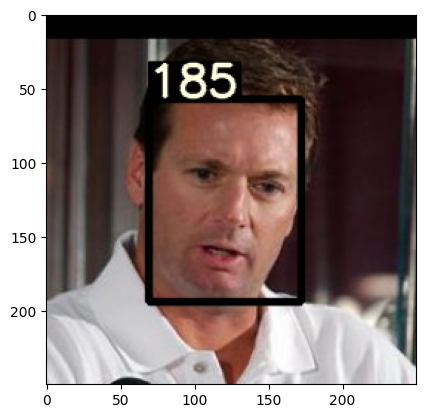

In [37]:
print_ID_results("Face Data/Face Dataset/185/2.jpg", labels, verbose=True)

Matching face(s) found in database! 
Nearest neighbours found in the database have labels 1681 and is at a distance of 5.960464477539063e-08
Nearest neighbours found in the database have labels 1681 and is at a distance of 0.1131218671798706
Nearest neighbours found in the database have labels 1681 and is at a distance of 0.4429405927658081


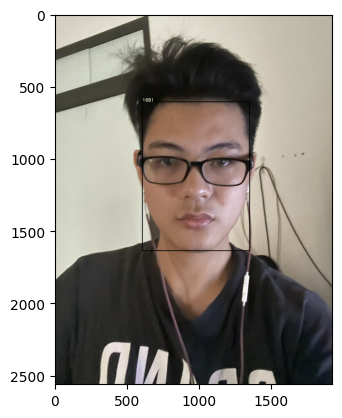

In [57]:
print_ID_results("Face Data\Face Dataset\\1681\e213951aaf487c162559.jpg", labels, verbose=True)

Matching face(s) found in database! 
Nearest neighbours found in the database have labels 1680 and is at a distance of 0.2920075058937073
Nearest neighbours found in the database have labels 1680 and is at a distance of 0.3087313175201416
Nearest neighbours found in the database have labels 1680 and is at a distance of 0.34775257110595703


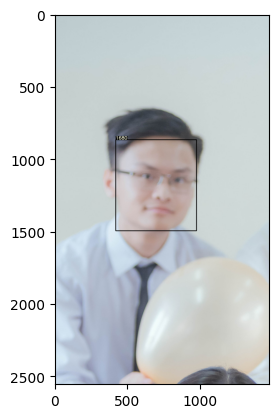

In [50]:
print_ID_results("DSC_3459.jpg", labels)

Matching face(s) found in database! 
Nearest neighbours found in the database have labels 1680 and is at a distance of 0.23849397897720337
Nearest neighbours found in the database have labels 1680 and is at a distance of 0.24521803855895996
Nearest neighbours found in the database have labels 1680 and is at a distance of 0.2568129301071167


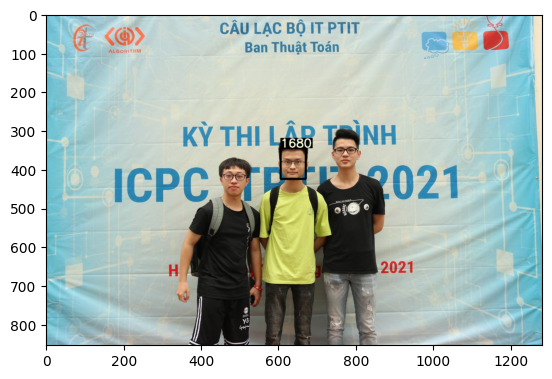

In [51]:
print_ID_results("thumbnail.jpg", labels, verbose=True)

Matching face(s) found in database! 
Nearest neighbours found in the database have labels 1680 and is at a distance of 0.25811660289764404
Nearest neighbours found in the database have labels 1680 and is at a distance of 0.2635205388069153
Nearest neighbours found in the database have labels 1680 and is at a distance of 0.27733737230300903


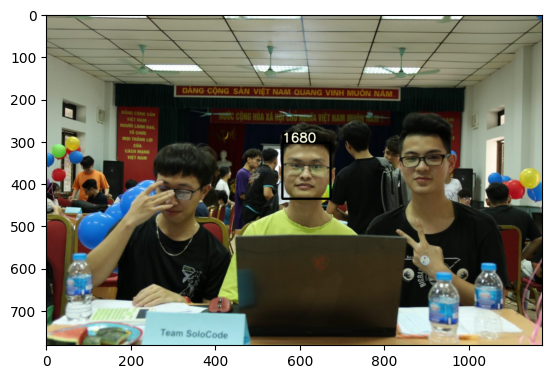

In [54]:
print_ID_results("thumbnail (2).jpg", labels, verbose=True)

Matching face(s) found in database! 
Nearest neighbours found in the database have labels 1680 and is at a distance of 0.2743833065032959
Nearest neighbours found in the database have labels 1680 and is at a distance of 0.28202682733535767
Nearest neighbours found in the database have labels 1680 and is at a distance of 0.28913724422454834


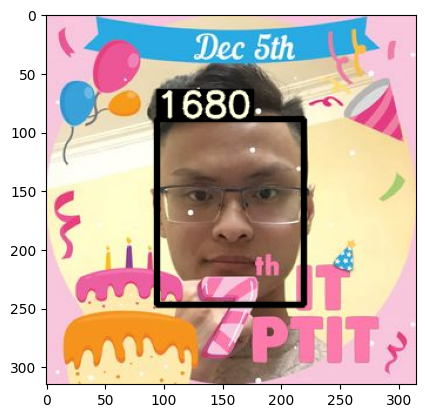

In [55]:
print_ID_results("127953314_1101131300345929_223365274437402144_o.jpg", labels)

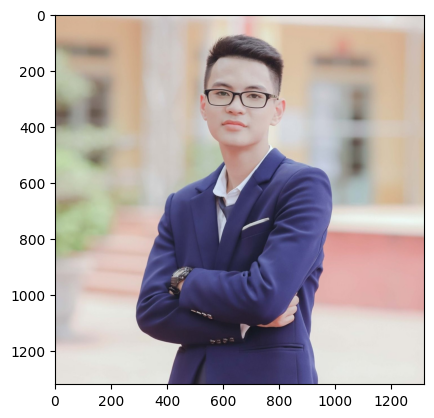

In [56]:
print_ID_results("103842145_1122359701470570_1804119268078544530_n.jpg", labels, verbose=True)